In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [13]:
df= spark.read.csv('feature_df.csv', header=True)

In [14]:
df=df.drop('cat_gender','cat_level','cat_method','cat_location_state','cat_user_agent')

In [15]:
df

DataFrame[userId: string, count_per_activetime_Submit_Downgrade: string, count_per_activetime_Thumbs_Down: string, count_per_activetime_Home: string, count_per_activetime_Downgrade: string, count_per_activetime_Roll_Advert: string, count_per_activetime_Logout: string, count_per_activetime_Save_Settings: string, count_per_activetime_About: string, count_per_activetime_Settings: string, count_per_activetime_Add_to_Playlist: string, count_per_activetime_Add_Friend: string, count_per_activetime_NextSong: string, count_per_activetime_Thumbs_Up: string, count_per_activetime_Help: string, count_per_activetime_Upgrade: string, count_per_activetime_Error: string, count_per_activetime_Submit_Upgrade: string, weely_page_std_Home: string, weely_page_std_Add_to_Playlist: string, weely_page_std_NextSong: string, weely_page_std_Thumbs_Up: string, daily_page_std_Home: string, daily_page_std_Logout: string, daily_page_std_Add_to_Playlist: string, daily_page_std_NextSong: string, daily_page_std_Thumbs_U

# Modeling

### Numerical features encoding

In [16]:
# convert all string type numerical values to float
num_features_list = df.columns[1:]
for f in num_features_list:
    f_name = f + "_Num"
    df = df.withColumn(f_name, df[f].cast("float"))
    df = df.drop(f)

In [17]:
df

DataFrame[userId: string, count_per_activetime_Submit_Downgrade_Num: float, count_per_activetime_Thumbs_Down_Num: float, count_per_activetime_Home_Num: float, count_per_activetime_Downgrade_Num: float, count_per_activetime_Roll_Advert_Num: float, count_per_activetime_Logout_Num: float, count_per_activetime_Save_Settings_Num: float, count_per_activetime_About_Num: float, count_per_activetime_Settings_Num: float, count_per_activetime_Add_to_Playlist_Num: float, count_per_activetime_Add_Friend_Num: float, count_per_activetime_NextSong_Num: float, count_per_activetime_Thumbs_Up_Num: float, count_per_activetime_Help_Num: float, count_per_activetime_Upgrade_Num: float, count_per_activetime_Error_Num: float, count_per_activetime_Submit_Upgrade_Num: float, weely_page_std_Home_Num: float, weely_page_std_Add_to_Playlist_Num: float, weely_page_std_NextSong_Num: float, weely_page_std_Thumbs_Up_Num: float, daily_page_std_Home_Num: float, daily_page_std_Logout_Num: float, daily_page_std_Add_to_Playl

### Vector Assembler

In [18]:
assembler = VectorAssembler(inputCols=df.columns[1:-2], outputCol="Features")
data = assembler.transform(df)

### Standard scaler

In [19]:
scaler = StandardScaler(inputCol="Features", outputCol="StdFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

### PCA

In [20]:
data

DataFrame[userId: string, count_per_activetime_Submit_Downgrade_Num: float, count_per_activetime_Thumbs_Down_Num: float, count_per_activetime_Home_Num: float, count_per_activetime_Downgrade_Num: float, count_per_activetime_Roll_Advert_Num: float, count_per_activetime_Logout_Num: float, count_per_activetime_Save_Settings_Num: float, count_per_activetime_About_Num: float, count_per_activetime_Settings_Num: float, count_per_activetime_Add_to_Playlist_Num: float, count_per_activetime_Add_Friend_Num: float, count_per_activetime_NextSong_Num: float, count_per_activetime_Thumbs_Up_Num: float, count_per_activetime_Help_Num: float, count_per_activetime_Upgrade_Num: float, count_per_activetime_Error_Num: float, count_per_activetime_Submit_Upgrade_Num: float, weely_page_std_Home_Num: float, weely_page_std_Add_to_Playlist_Num: float, weely_page_std_NextSong_Num: float, weely_page_std_Thumbs_Up_Num: float, daily_page_std_Home_Num: float, daily_page_std_Logout_Num: float, daily_page_std_Add_to_Playl

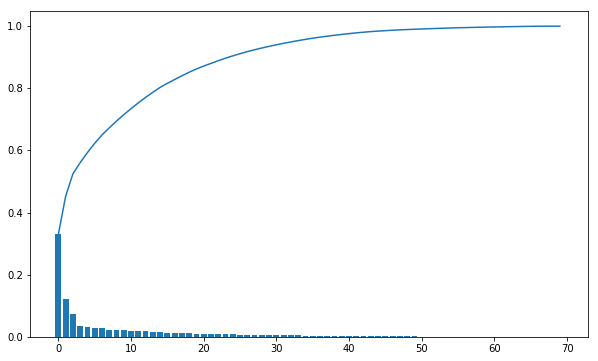

In [22]:
pca = PCA(k=70, inputCol="StdFeatures", outputCol="pcaFeatures")
model = pca.fit(data)

ind=np.arange(70)
val=np.array(model.explainedVariance)
cumvals=np.cumsum(val)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.bar(ind, val)
ax.plot(ind,cumvals)

In [23]:
k=len(val[val>0.01])
print(k)

20


In [24]:
k=len(val[val>0.005])
print(k)

30


In [25]:
pca17 = PCA(k=20, inputCol="StdFeatures", outputCol="pcaFeatures")
model17 = pca17.fit(data)
data17 = model17.transform(data)

In [26]:
pca76 = PCA(k=30, inputCol="StdFeatures", outputCol="pcaFeatures")
model76 = pca76.fit(data)
data76 = model76.transform(data)

## PCA 17 components

### split the data

In [27]:
data_churn = data17.select(data17.Churn_Num.alias("label"), data17.pcaFeatures.alias("features"))
data_churn.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   99|
|  0.0|  349|
+-----+-----+



In [28]:
train, validation = data_churn.randomSplit([0.8, 0.2], seed=110)

###  handle unbalanced data

In [29]:
# method 1, Augmentation
oversampled_train=train.sample(True, 2.0, 110)
oversampled_train.select('label').groupby('label').count().show()
# method 2, under sample the popular class
stratified_train = train.sampleBy('label', fractions={0: 0.3, 1: 1.0}).cache()
stratified_train.select('label').groupby('label').count().show()
# method 3,Augmentation then under sample the popular class
stratified_train2 = oversampled_train.sampleBy('label', fractions={0: 0.3, 1: 1.0}).cache()
stratified_train2.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  150|
|  0.0|  566|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   80|
|  0.0|   89|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  150|
|  0.0|  173|
+-----+-----+



### Model training and cross validation

In [30]:
# define the evaluation metrics
def evaluate_result(results,model_name):
    """
    This function print out the f1 score, accuracy, recall and precision from prediction result 
    input: results - a pyspark data frame containing the predicted result
           model_name - a string that contains the model's name
    output: None
    """
    print(model_name," f1 score: ", MulticlassClassificationEvaluator(metricName="f1").evaluate(results))
    print(model_name," accuracy: ", MulticlassClassificationEvaluator(metricName="accuracy").evaluate(results))
    rdd=results.select('label','prediction').rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(rdd)
    print("label 1 recall: ", metrics.recall(1),", precision: ",metrics.precision(1))
    print("label 0 recall: ", metrics.recall(0),", precision: ",metrics.precision(0))
    pass

In [31]:
def three_modelcomparison(train,validation):
    """
    This function will trained a logistic regreession,a  random forest and a gradient boost tree using training data and evaluate model's performance using validation data.
    input: train - training data set
           validation - validation dataset
    output: cvModel_lr - best trained logistic regression model
            cvModel_rf - best trained random forest model
            cvModel_gbts - best trained gradient boost tree model
    
    """
    lr =  LogisticRegression(featuresCol = 'features', labelCol = 'label')
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.2]) \
        .addGrid(lr.regParam,[0.0, 0.1, 0.2, 0.3]) \
        .addGrid(lr.maxIter,[5, 10, 15, 20, 25]) \
        .build()

    crossval_lr = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=10)
    cvModel_lr = crossval_lr.fit(train)
    lr_avgMetrics=cvModel_lr.avgMetrics
    results_lr = cvModel_lr.transform(validation)
    evaluate_result(results_lr,"logistic regression")
    #--------------------------------------------------------
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',)
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.impurity,['entropy','gini']) \
        .addGrid(rf.maxDepth,[10, 15, 20, 25]) \
        .addGrid(rf.numTrees,[20, 30, 40]) \
        .build()
    crossval_rf = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=10)
    cvModel_rf= crossval_rf.fit(train)
    rf_avgMetrics = cvModel_rf.avgMetrics
    results_rf = cvModel_rf.transform(validation)
    evaluate_result(results_rf,"random forest")
    #-----------------------------------------------------------
    gbts = GBTClassifier()
    paramGrid = ParamGridBuilder() \
        .addGrid(gbts.maxIter,[20, 30, 40]) \
        .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
        .build()
    crossval_gbts = CrossValidator(estimator=gbts,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=10)
    cvModel_gbts = crossval_gbts.fit(train)
    gbts_avgMetrics = cvModel_gbts.avgMetrics
    results_gbts = cvModel_gbts.transform(validation)
    evaluate_result(results_gbts,"GBT")
    return cvModel_lr,cvModel_rf,cvModel_gbts

In [32]:
lr_model1,rf_model1,gbts_model1=three_modelcomparison(oversampled_train,validation)

logistic regression  f1 score:  0.869172155495286
logistic regression  accuracy:  0.8764044943820225
label 1 recall:  0.5789473684210527 , precision:  0.7857142857142857
label 0 recall:  0.9571428571428572 , precision:  0.8933333333333333
random forest  f1 score:  0.7948006168759638
random forest  accuracy:  0.8314606741573034
label 1 recall:  0.2631578947368421 , precision:  0.8333333333333334
label 0 recall:  0.9857142857142858 , precision:  0.8313253012048193
GBT  f1 score:  0.8164969844032987
GBT  accuracy:  0.8202247191011236
label 1 recall:  0.5263157894736842 , precision:  0.5882352941176471
label 0 recall:  0.9 , precision:  0.875


In [33]:
lr_model2,rf_model2,gbts_model2=three_modelcomparison(stratified_train,validation)

logistic regression  f1 score:  0.8330151781772508
logistic regression  accuracy:  0.8314606741573034
label 1 recall:  0.631578947368421 , precision:  0.6
label 0 recall:  0.8857142857142857 , precision:  0.8985507246376812
random forest  f1 score:  0.8110414866032843
random forest  accuracy:  0.797752808988764
label 1 recall:  0.7894736842105263 , precision:  0.5172413793103449
label 0 recall:  0.8 , precision:  0.9333333333333333
GBT  f1 score:  0.762637269450922
GBT  accuracy:  0.7415730337078652
label 1 recall:  0.7894736842105263 , precision:  0.4411764705882353
label 0 recall:  0.7285714285714285 , precision:  0.9272727272727272


In [34]:
lr_model3,rf_model3,gbts_model3=three_modelcomparison(stratified_train2,validation)

logistic regression  f1 score:  0.8284573048953394
logistic regression  accuracy:  0.8202247191011236
label 1 recall:  0.7368421052631579 , precision:  0.56
label 0 recall:  0.8428571428571429 , precision:  0.921875
random forest  f1 score:  0.8696062694740817
random forest  accuracy:  0.8651685393258427
label 1 recall:  0.7894736842105263 , precision:  0.6521739130434783
label 0 recall:  0.8857142857142857 , precision:  0.9393939393939394
GBT  f1 score:  0.7785310590120316
GBT  accuracy:  0.7640449438202247
label 1 recall:  0.6842105263157895 , precision:  0.4642857142857143
label 0 recall:  0.7857142857142857 , precision:  0.9016393442622951


## PCA 76 components

In [35]:
data_churn = data76.select(data76.Churn_Num.alias("label"), data76.pcaFeatures.alias("features"))
data_churn.select('label').groupby('label').count().show()

train, validation = data_churn.randomSplit([0.8, 0.2], seed=110)

# method 1, Augmentation
oversampled_train=train.sample(True, 2.0, 110)
oversampled_train.select('label').groupby('label').count().show()
# method 2, under sample the popular class
stratified_train = train.sampleBy('label', fractions={0: 0.3, 1: 1.0}).cache()
stratified_train.select('label').groupby('label').count().show()
# method 3,Augmentation then under sample the popular class
stratified_train2 = oversampled_train.sampleBy('label', fractions={0: 0.3, 1: 1.0}).cache()
stratified_train2.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   99|
|  0.0|  349|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  150|
|  0.0|  566|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   80|
|  0.0|   80|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  150|
|  0.0|  171|
+-----+-----+



In [36]:
lr76_model1,rf76_model1,gbts76_model1=three_modelcomparison(oversampled_train,validation)

logistic regression  f1 score:  0.8724040004938881
logistic regression  accuracy:  0.8764044943820225
label 1 recall:  0.631578947368421 , precision:  0.75
label 0 recall:  0.9428571428571428 , precision:  0.9041095890410958
random forest  f1 score:  0.8294984470295134
random forest  accuracy:  0.8539325842696629
label 1 recall:  0.3684210526315789 , precision:  0.875
label 0 recall:  0.9857142857142858 , precision:  0.8518518518518519
GBT  f1 score:  0.857677235839036
GBT  accuracy:  0.8539325842696629
label 1 recall:  0.7368421052631579 , precision:  0.6363636363636364
label 0 recall:  0.8857142857142857 , precision:  0.9253731343283582


In [37]:
lr76_model2,rf76_model2,gbts76_model2=three_modelcomparison(stratified_train,validation)

logistic regression  f1 score:  0.8013772532791532
logistic regression  accuracy:  0.7865168539325843
label 1 recall:  0.7894736842105263 , precision:  0.5
label 0 recall:  0.7857142857142857 , precision:  0.9322033898305084
random forest  f1 score:  0.7820412071756067
random forest  accuracy:  0.7640449438202247
label 1 recall:  0.7894736842105263 , precision:  0.46875
label 0 recall:  0.7571428571428571 , precision:  0.9298245614035088
GBT  f1 score:  0.8304096164379505
GBT  accuracy:  0.8202247191011236
label 1 recall:  0.7894736842105263 , precision:  0.5555555555555556
label 0 recall:  0.8285714285714286 , precision:  0.9354838709677419


In [38]:
lr76_model3,rf76_model3,gbts76_model3=three_modelcomparison(stratified_train2,validation)

logistic regression  f1 score:  0.8070144680072568
logistic regression  accuracy:  0.797752808988764
label 1 recall:  0.6842105263157895 , precision:  0.52
label 0 recall:  0.8285714285714286 , precision:  0.90625
random forest  f1 score:  0.8651685393258427
random forest  accuracy:  0.8651685393258427
label 1 recall:  0.6842105263157895 , precision:  0.6842105263157895
label 0 recall:  0.9142857142857143 , precision:  0.9142857142857143


Py4JJavaError: An error occurred while calling o1317769.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 457647.0 failed 1 times, most recent failure: Lost task 0.0 in stage 457647.0 (TID 459175, localhost, executor driver): java.io.FileNotFoundException: File file:/G:/operation d/DS-project-Spark-Project-Sparkify/feature_df.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:409)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$countByKey$1.apply(PairRDDFunctions.scala:370)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$countByKey$1.apply(PairRDDFunctions.scala:370)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.countByKey(PairRDDFunctions.scala:369)
	at org.apache.spark.rdd.RDD$$anonfun$countByValue$1.apply(RDD.scala:1214)
	at org.apache.spark.rdd.RDD$$anonfun$countByValue$1.apply(RDD.scala:1214)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.countByValue(RDD.scala:1213)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:42)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:42)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:215)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:215)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:84)
	at sun.reflect.GeneratedMethodAccessor128.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: File file:/G:/operation d/DS-project-Spark-Project-Sparkify/feature_df.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:127)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:177)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:101)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:409)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
